# License 
***
Copyright (C) 2017 -- 2022 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

***
# **Basic** Gradient Descent for Multiple Linear Regression

#### Installs and Imports

In [ ]:
# imports 
import pandas as pd # import pandas for easy data manipulation using data frames
import numpy as np  # import numpy for numeric calculations on matrices
import time         # for timers

# to upload local files
import io
from google.colab import files  

In [ ]:
# install Java for h2o backend
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
openjdk version "11.0.13" 2021-10-19
OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [ ]:
# install h2o
!pip install h2o 

     |████████████████████████████████| 175.8 MB 38 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.7-py2.py3-none-any.whl size=175908084 sha256=3ac669bf9a6c08c4da81d517529d1244c6655102f1aca1cb9e697492e47dff90
  Stored in directory: /root/.cache/pip/wheels/df/df/05/1f2ac68a5d9bf38b74f2b8218443b2c00f1a5f4f3154ec11b6
Successfully built h2o


In [ ]:
# import h2o to check calculations
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

#### Load example data

In [ ]:
# special google collab command to upload a file from computer
uploaded = files.upload()

Saving loan_clean.csv to loan_clean.csv


In [ ]:
uploaded.keys() # what is stored in that Python object?

dict_keys(['loan_clean.csv'])

In [ ]:
raw = pd.read_csv(io.StringIO(uploaded['loan_clean.csv'].decode('utf-8')))

#### Assign global constants

In [ ]:
Y            = 'STD_IMP_REP_loan_amnt'
DROPS        = ['id', 'GRP_REP_home_ownership', 'GRP_addr_state', 'GRP_home_ownership',
                'GRP_purpose', 'GRP_verification_status', '_WARN_']

# model-related constants
LEARN_RATE   = 0.05 # how much each gradient descent step impacts parameters
CONV         = 1e-10 # desired precision in parameters 
MAX_ITERS    = 10000 # maximum number of gradient descent steps to allow

### Clean data and convert to numpy matrices

In [ ]:
raw.describe()

,id,bad_loan,GRP_REP_home_ownership,GRP_addr_state,GRP_home_ownership,GRP_purpose,GRP_verification_status,_WARN_,STD_IMP_REP_annual_inc,STD_IMP_REP_delinq_2yrs,STD_IMP_REP_dti,STD_IMP_REP_emp_length,STD_IMP_REP_int_rate,STD_IMP_REP_loan_amnt,STD_IMP_REP_longest_credit_lengt,STD_IMP_REP_revol_util,STD_IMP_REP_term_length,STD_IMP_REP_total_acc
count,163987.000000,163987.000000,163987.000000,163987.000000,163987.000000,163987.000000,163987.000000,0.0,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05
mean,91994.000000,0.192595,2.574003,11.409337,2.574003,3.244940,2.340356,NaN,2.387342e-11,2.408736e-12,6.806950e-11,-3.563309e-11,-8.939301e-12,8.310596e-11,5.061841e-11,-1.473947e-11,-1.500741e-10,8.045720e-13
std,47339.113634,0.394338,0.667526,9.971926,0.667526,2.267289,0.504086,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,10001.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,-1.767456e+00,-3.921962e-01,-2.119639e+00,-1.621390e+00,-1.907046e+00,-1.587129e+00,-2.224451e+00,-2.164541e+00,-5.164956e-01,-2.058862e+00
25%,50997.500000,0.000000,2.000000,3.000000,2.000000,2.000000,2.000000,NaN,-6.595203e-01,-3.921962e-01,-7.380602e-01,-7.663281e-01,-6.840838e-01,-7.667612e-01,-7.212383e-01,-7.235035e-01,-5.164956e-01,-7.471426e-01
50%,91994.000000,0.000000,3.000000,8.000000,3.000000,2.000000,2.000000,NaN,-2.225562e-01,-3.921962e-01,-2.257573e-02,8.873407e-02,-5.191344e-02,-2.114351e-01,-1.199531e-01,7.707309e-02,-5.164956e-01,-1.350069e-01
75%,132990.500000,0.000000,3.000000,17.000000,3.000000,3.000000,3.000000,NaN,3.686305e-01,-3.921962e-01,6.955785e-01,1.228817e+00,5.917510e-01,6.215541e-01,4.813321e-01,7.815805e-01,-5.164956e-01,5.645768e-01
max,173987.000000,1.000000,5.000000,37.000000,5.000000,14.000000,3.000000,NaN,4.618062e+00,4.156695e+00,3.037149e+00,1.228817e+00,2.837680e+00,2.767132e+00,3.143160e+00,3.036350e+00,1.971879e+00,3.068467e+00


In [ ]:
# select target column
y = raw[Y].values
print(y)

[-1.01918221 -1.33470843 -1.34732948 ... -0.03158515  1.83948532
  0.49534363]


In [ ]:
# create input matrix
# add an additional column of 1's for intercept 
# by overlaying inputs onto matrix of 1's
numeric = raw.drop(DROPS + [Y], axis=1).values
N, p = numeric.shape
X = np.ones(shape=(N, p + 1))
X[:,1:] = numeric 

### Linear Regression by Solving the Normal Equation 

\begin{equation}
X\hat{\beta} = y 
\end{equation}

\begin{equation}
\hat{\beta} = (X^{T}X)^{-1}X^Ty
\end{equation}

The normal equation estimates coefficients that globally minimize the squared error between a rectangular input data matrix $X$ and a column vector of target values $y$. I.e. it presents an optimal solution to an underspecified set of linear equations.

In [ ]:
X_transpose = np.transpose(X)
beta_hat = np.linalg.inv(X_transpose.dot(X))
beta_hat = beta_hat.dot(X_transpose)
beta_hat = beta_hat.dot(y)
print('Model parameters:\n', beta_hat)

Model parameters:
 [-0.00953184  0.04949174  0.4184344  -0.04237427  0.08966404  0.0301429
  0.08011731  0.05023822  0.01554239  0.31239211  0.04139277]


### Basic Gradient Descent Routines with L2 ("Ridge"/"Tikhonov") Regularization
\begin{equation}
\tilde{\beta} = \underset{\beta}{argmin}\sum_{i=0}^{N-1} (y^{(i)} - \beta_0 - \sum_{j=0}^{P-1}\beta x_j)^2 + \lambda\sum_{j=0}^{P-1} \beta^2_j
\end{equation}

#### Define squared loss function
* For linear regression, we directly minimize the squared distance between the regression plane and points in the conditional distribution of **y** given **X**.
* Direct minimization of the squared loss function is typically preferred to solving the normal equation directly due to numerical stability and scalability issues.
* It is convenient to use a scaled mean squared error (MSE) formula:
\begin{equation}
\frac{1}{2N}\sum_{i=0}^{N-1} (y^{(i)} - \beta_0 - \sum_{j=0}^{P-1}\beta x_j)^2 + \lambda\sum_{j=0}^{P-1} \beta^2_j
\end{equation}

In [ ]:
def squared_loss(n, x, y, betas, lambda_=0):
    
    """ Squared loss function for multiple linear regression.
    
    :param n: Number of rows in x.
    :param x: Matrix of numeric inputs.
    :param y: Vector of known target values.
    :param beta: Vector of current model parameters.
    :param lambda_: Scale factor for L2 regularization, default 0.
    :return: Scalar MSE value.    
    
    """
    
    yhat = x.dot(betas)
        
    return (1 / (2 * n)) * (((y - yhat)**2).sum() + lambda_ * (betas**2).sum())

#### Define gradient of loss function
* The derivative of the loss function w.r.t the model parameters is used to update model parameters at each gradient descent step.
* The gradient of our MSE loss function is trivial:

In [ ]:
def grad(n, y, yhat, x, beta_j, lambda_=0):
    
    """ Analytical gradient of scaled MSE loss function with L2 regularization.
    
    :param n: Number of rows in X.
    :param y: Vector of known target values.
    :param yhat: Vector of predicted target values.
    :param x: Vector of input values.
    :param beta_j: Model parameter for which to calculate gradient.
    :param lambda_: Scale factor for L2 regularization, default 0.
    :return: Vector of gradient values.
    
    """
    
    return (1 / n) * (x * (yhat - y) + (lambda_ * beta_j))

#### Define function for executing gradient descent minimization
For each gradient descent step:
* Predictions are made using the current model parameters.
* The gradient is calculated for each model pararmeter.
* The gradient is used in combination with the learning rate to update each parameter.

In [ ]:
def grad_descent(X, y, learn_rate, max_iters, sgd_mini_batch_n=0, lambda_=0):
    
    """ Routine for executing simple gradient descent with stochastic gradient descent option.
    
    :param X: Matrix of numeric data.
    :param y: Vector of known target values.
    :param learn_rate: Learning rate.
    :param max_iters: Maximum number of gradient descent steps to perform.
    :param sgd_mini_batch_n: Minibatch size for sgd optimization.
                             If > 0 minibatch stochastic gradient descent is performed.
    :param lambda_: Scale factor for L2 regularization, default 0.
    
    """

    tic = time.time()               # start timer
    n_betas = X.shape[1]            # number of model parameters including bias    
    betas = np.zeros(shape=n_betas) # parameters start with value of 0
    n = y.shape[0]                  # number of rows in X
    
    # Pandas dataframe for iteration history
    iteration_frame = pd.DataFrame(columns=['Iteration', 'Loss'])

    print('Iteration history:')
    
    # loop for gradient descent steps
    for i in range(max_iters):
        
        # stochastic gradient descent
        if sgd_mini_batch_n > 0:
            
            samp_idx = np.random.randint(n, size=sgd_mini_batch_n)
            X_samp = X[samp_idx, :]
            y_samp = y[samp_idx]
            n_samp = X_samp.shape[0]
            yhat_samp = X_samp.dot(betas) # model predictions for iteration

            # loop for column-wise parameter updates
            for j in range(n_betas):

                # select column
                # calculate column-wise gradient
                # update corresponding parameter based on negative gradient
                # calculate loss

                xj_samp = X_samp[:, j]
                beta_j = betas[j]
                xj_grad_samp = grad(n_samp, y_samp, yhat_samp, xj_samp, beta_j, lambda_)
                betas[j] = betas[j] - learn_rate * xj_grad_samp.sum()
                iter_loss = squared_loss(n_samp, X_samp, y_samp, betas, lambda_)
        
        # standard gradient descent
        else:
            
            yhat = X.dot(betas) # model predictions for iteration

            # loop for column-wise parameter updates
            for j in range(n_betas):
                xj = X[:, j]
                beta_j = betas[j]
                xj_grad = grad(n, y, yhat, xj, beta_j, lambda_)
                betas[j] = betas[j] - learn_rate * xj_grad.sum()
                iter_loss = squared_loss(n, X, y, betas, lambda_)
        
        # update loss history
        iteration_frame = iteration_frame.append({'Iteration': i,
                                                  'Loss':  iter_loss}, 
                                                  ignore_index=True)        
        # progress indicator 
        if i % 1000 == 0:
            print('iter=%d loss=%.6f' % (i, iter_loss))
        
        # convergence check
        if i > 0:
            if np.abs(iteration_frame.iat[i-1, 1] - iteration_frame.iat[i, 1]) < CONV:
                break

    # output 
    %matplotlib inline
    iteration_frame.plot.line(title='Iteration Plot', x='Iteration', y='Loss')
    print()           
    print('Model parameters at iteration ' + str(i) + ':')
    print(betas)
    print()
    print('Model trained in %.2f s.' % (time.time()-tic))


#### Execute gradient descent

Iteration history:
iter=0 loss=0.472967

Model parameters at iteration 709:
[-0.00946269  0.04918263  0.41842662 -0.04237465  0.08967229  0.03014185
  0.08014273  0.05024078  0.01554251  0.3123994   0.04138562]

Model trained in 47.20 s.


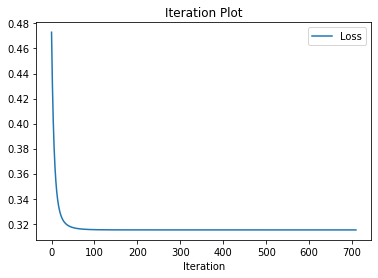

In [ ]:
grad_descent(X, y, LEARN_RATE, MAX_ITERS)

#### Execute L2 penalized gradient descent

Iteration history:
iter=0 loss=0.472967

Model parameters at iteration 962:
[-0.00887026  0.04652247  0.41326281 -0.04186768  0.08725817  0.03035732
  0.08097103  0.050572    0.01624763  0.30948716  0.04325793]

Model trained in 65.22 s.


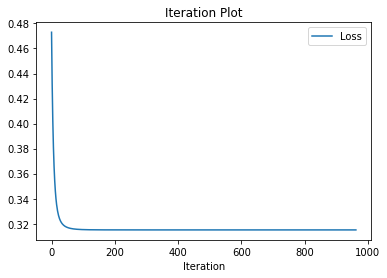

In [ ]:
grad_descent(X, y, LEARN_RATE, MAX_ITERS, lambda_=0.01)

#### Execute stochastic gradient descent

Iteration history:
iter=0 loss=0.439249
iter=1000 loss=0.320123
iter=2000 loss=0.315571
iter=3000 loss=0.310116
iter=4000 loss=0.337577
iter=5000 loss=0.292644
iter=6000 loss=0.289687
iter=7000 loss=0.301630
iter=8000 loss=0.343404
iter=9000 loss=0.321595

Model parameters at iteration 9999:
[-0.00232352  0.04909765  0.41894127 -0.04403398  0.08710958  0.02783919
  0.08525565  0.05318875  0.01350517  0.30850027  0.03727043]

Model trained in 37.36 s.


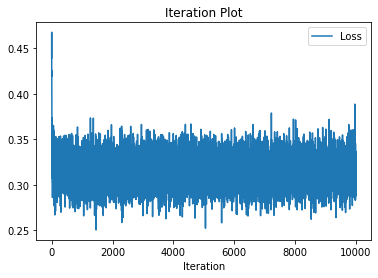

In [ ]:
grad_descent(X, y, LEARN_RATE, MAX_ITERS, sgd_mini_batch_n=1000)

#### Execute L2 penalized stochastic gradient descent

Iteration history:
iter=0 loss=0.522797
iter=1000 loss=0.291220
iter=2000 loss=0.304839
iter=3000 loss=0.306702
iter=4000 loss=0.328873
iter=5000 loss=0.304997
iter=6000 loss=0.308997
iter=7000 loss=0.322125
iter=8000 loss=0.325605
iter=9000 loss=0.317328

Model parameters at iteration 9999:
[-0.00566562  0.0475607   0.42188972 -0.04180237  0.08237843  0.02679364
  0.07306504  0.0479515   0.01217848  0.31191062  0.04560815]

Model trained in 38.61 s.


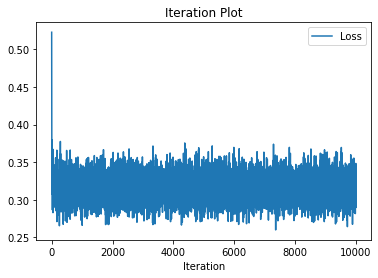

In [ ]:
grad_descent(X, y, LEARN_RATE, MAX_ITERS, lambda_=0.01, sgd_mini_batch_n=1000)

### Use h2o to check model parameters

In [ ]:
# start h2o
h2o.init()

DROPS = ['id', 'GRP_REP_home_ownership', 'GRP_addr_state', 'GRP_home_ownership',
         'GRP_purpose', 'GRP_verification_status', '_WARN_']

# numeric columns 
train = h2o.H2OFrame(raw)
train = train.drop(DROPS)
X = train.col_names

# initialize non-penalized GLM model
loan_glm = H2OGeneralizedLinearEstimator(family='gaussian',      # uses squared error
                                         solver='IRLSM',         # necessary for non-penalized GLM
                                         standardize=False,      # data is already standardized
                                         compute_p_values=True,  # necessary for non-penalized GLM 
                                         lambda_=0)              # necessary for non-penalized GLM

# train 
loan_glm.train(train.col_names, Y, training_frame=train)

# print trained model info
print() 
print('Model parameters:')
for name, val in loan_glm.coef().items():
    print(name, val)
print()

# shutdown h2o
h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,15 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_unknownUser_4uoy5r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Model parameters:
Intercept -0.009531837795375258
bad_loan 0.04949173616041542
STD_IMP_REP_annual_inc 0.41843440383336206
STD_IMP_REP_delinq_2yrs -0.04237426505134592
STD_IMP_REP_dti 0.08966404330350629
STD_IMP_REP_emp_length 0.0301429030204786
STD_IMP_REP_int_rate 0.08011731349761636
STD_IMP_REP_longest_credit_lengt 0.05023821933457022
STD_IMP_REP_revol_util 0.015542387042662822
STD_IMP_REP_term_length 0.31239210762624064
STD_IMP_REP_total_acc 0.0413927677379069

H2O session _sid_b3f1 closed.
